<a href="https://colab.research.google.com/github/saumya07p/Deep-Learning-lab-assignments/blob/main/IS675_lab05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IS 675 Lab 5 - Using a Neural Network to Fit the Data (1)

##1. Buiding a model

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import required libraries
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

Consider the thermometer example

In [ ]:
# Load the data in tensors: observed values in unkown units (t_u) versus ground truth values in Celsius (t_c)
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [ ]:
t_c

tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000,
        -4.0000,  6.0000, 13.0000, 21.0000])

In [ ]:
t_u

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

We want to estimate a linear model like this: t_c = w * t_u + b

What should we estimate?

In [ ]:
# Choose a linear model as a first try
# Notice how broadcasting works
def model(t_u, w, b):
    return w * t_u + b

In [ ]:
# More on broadcasting
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


##2. Defining a loss function to penalize the difference between the model estimates and gound truth

In [ ]:
# Define the loss function: let's consider the nicer behaving "mean square loss"
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [ ]:
# Initialize the parameters
w = torch.ones(())
b = torch.zeros(())

# Invoke the model
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [ ]:
# Check the value of the loss with the given w and b
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

##3. Decreasing loss

###3.1. Computing the derivatives

Recall that our model is a linear function, and our loss is a sum of squares. Let’s figure out the expressions for the derivatives. Remembering that d x^2 / d x = 2 x, we have

In [ ]:
# Define a function that returns the derivative of loss wrt t_p (the linear model)
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs
# <1> The division is from the derivative of mean

In [ ]:
# Define a function that returns the derivative of t_p (the linear model) wrt w (weight)
def dmodel_dw(t_u, w, b):
    return t_u

In [ ]:
# Define a function that returns the derivative of t_p (the linear model) wrt b (bias)

def dmodel_db(t_u, w, b):
    return 1.0

Now let's use the chain rule to define our gradient function.

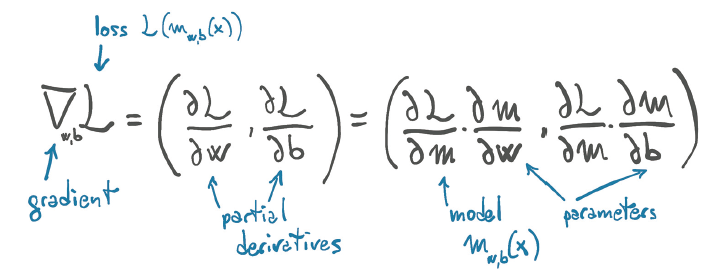

In [ ]:
# Define the gradient function that employs the chain rule
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>
    # <1> The summation is the reverse of the broadcasting we implicitly do when applying the parameters to an entire vector of inputs in the model.

###3.2. Iterating to reduce the loss and fit the model

We now have everything in place to optimize our parameters. Starting from a tentative value for a parameter, we can iteratively apply updates to it for a fixed number of iterations, or until w and b stop changing. There are several stopping criteria; for now, we’ll stick to a fixed number of iterations or **epochs**.

**Epoch**: We call a training iteration during which we update the parameters for all of our training samples an epoch.

Also we typically should scale the rate of change by a small factor. This scaling factor has many names; the one we use in machine learning is **learning_rate**.

In [ ]:
# Define a training loop to obtain estimated params w and b
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1> Forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2> Backward pass

        params = params - learning_rate * grad # updating/changing params with a scale/learning rate

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3> This logging line can be very verbose.

    return params

In [ ]:
# Define a more detailed training loop to obtain estimated params w and b and to avoid verbosity
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1> Forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2> Backward pass

        params = params - learning_rate * grad # updating/changing params with a scale/learning rate

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>

    return params

In [ ]:
# Call the training loop
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

Wait, what happened? Our training process literally blew up, leading to losses becoming inf. This is a clear sign that params is receiving updates that are too large, and their values start oscillating back and forth as each update overshoots and the next overcorrects even more. The optimization process is unstable: it diverges instead of converging to a minimum. We want to see smaller and smaller updates to params, not larger!

Q1. We usually change learning rates by orders of magnitude. Try learning-rate = 1e-4 and see the results. Based on your results explain which model has a stable behaviour and why? (1 pts)

**Answer**: According to me, the second model having learning rate = 1e-4 is a more stable model, as the loss is decreasing which showcases that the model is becoming more stable by learning. The learning rate should be lower so that the model can **Learn**.

In [ ]:
#Q1
# Call the training loop
training_loop(
    n_epochs = 100,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

There’s another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls. We could obviate this issue by making learning_rate adaptive: that is, change according to the magnitude of updates. There are optimization schemes that do that!

##4. Normalizing inputs

We can see that the first-epoch gradient for the weight is about 50 times larger than the gradient for the bias. This means the weight and bias live in differently scaled spaces. If this is the case, a learning rate that’s large enough to meaningfully update one will be so large as to be unstable for the other; and a rate that’s appropriate for the other won’t be large enough to meaningfully change the first.

We could have individual learning rates for each parameter, but for models with many parameters, this would be too much to bother with; it’s babysitting of the kind we don’t like.

There’s a simpler way to keep things in check: changing the inputs so that the gradients aren’t quite so different. We can make sure the range of the input doesn’t get too far from the range of –1.0 to 1.0, roughly speaking. In our case, we can achieve something close enough to that by simply multiplying t_u by 0.1!

In [ ]:
# Perform normalization
t_un = 0.1 * t_u

#t_min = torch.min(t_u)
#t_max = torch.max(t_u)
#t_un = (t_u - t_min) / (t_max - t_min)
#t_un

In [ ]:
# Train the model with normalized input
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un, # We’ve updated t_u to our new, rescaled t_un
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [ ]:
# Train the model with more epochs and smaller learning_rate
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 80.364342
Epoch 2, Loss 79.752480
Epoch 3, Loss 79.148026
...
Epoch 10, Loss 75.116219
Epoch 11, Loss 74.567734
...
Epoch 99, Loss 45.087246
Epoch 100, Loss 44.900906
...
Epoch 4000, Loss 26.422497
Epoch 5000, Loss 25.637672


tensor([ 2.5233, -1.2029])

The exact values would be w=5.5556 and b=-17.7778. Our fancy thermometer was showing temperatures in Fahrenheit the whole time. No big discovery, except that our gradient descent optimization process works!

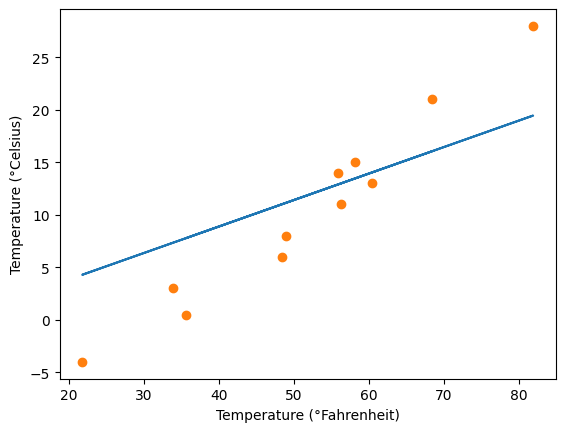

In [ ]:
# Plot the estimated model and the ground truth observations
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # Remember that we’re training on the normalized unknown units. We also use argument unpacking

fig = plt.figure(dpi=100)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # But we’re plotting the raw unknown values
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
#plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

Q2. Perform a min-max normalization on the input data (call it t_un_minmax) and train the model. Then compare the model performance to the previous model. Which one works better, why?

In [ ]:
#Q2
# Performing normalization
t_min = torch.min(t_u)
t_max = torch.max(t_u)
t_un_minmax = (t_u - t_min) / (t_max - t_min)
t_un_minmax

tensor([0.2313, 0.5674, 0.6057, 1.0000, 0.5740, 0.4509, 0.2013, 0.0000,
        0.4426, 0.6423, 0.7754])

In [ ]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un_minmax, # We’ve updated t_u to our new, rescaled t_un_minmax
    t_c = t_c)

Epoch 1, Loss 172.623627
    Params: tensor([1.1444, 0.2000])
    Grad:   tensor([-14.4422, -20.0017])
Epoch 2, Loss 166.612732
    Params: tensor([1.2859, 0.3946])
    Grad:   tensor([-14.1500, -19.4574])
Epoch 3, Loss 160.896347
    Params: tensor([1.4246, 0.5839])
    Grad:   tensor([-13.8650, -18.9270])
...
Epoch 10, Loss 127.982521
    Params: tensor([2.3211, 1.7711])
    Grad:   tensor([-12.0601, -15.5724])
Epoch 11, Loss 124.150726
    Params: tensor([2.4394, 1.9225])
    Grad:   tensor([-11.8273, -15.1405])
...
Epoch 99, Loss 45.086716
    Params: tensor([7.9886, 6.3701])
    Grad:   tensor([-3.6300, -0.3274])
Epoch 100, Loss 44.954426
    Params: tensor([8.0246, 6.3729])
    Grad:   tensor([-3.6035, -0.2846])


tensor([8.0246, 6.3729])

In [ ]:
# Train the model with more epochs and smaller learning_rate
params1 = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un_minmax,
    t_c = t_c,
    print_params = False)

params1

Epoch 1, Loss 172.623627
Epoch 2, Loss 172.562775
Epoch 3, Loss 172.501953
...
Epoch 10, Loss 172.077011
Epoch 11, Loss 172.016418
...
Epoch 99, Loss 166.800934
Epoch 100, Loss 166.742950
...
Epoch 4000, Loss 65.725945
Epoch 5000, Loss 58.470779


tensor([5.7095, 5.3540])

**Answer:** The previous model works better (the one without the min-max normalization) as it is producing lower loss as compared to the model having minmax normalization at the last epoch respectively.

Q3. Why your estimated weight and bias parameters are not similar to the actual ones when we convert F to C (in general, we have C = 0.5556*F - 17.7778)?

**Answer**: The differences between the estimated and actual parameters occur due to imperfections in data, the training process, and model characteristics. These factors prevent the model from perfectly capturing the true linear relationship between Fahrenheit and Celsius.

##5. PyTorch’s autograd: Backpropagating all things

we just saw a simple example of backpropagation: we computed the gradient of a composition of functions—the model and the loss—with respect to their innermost parameters (w and b) by propagating derivatives backward using the chain rule. But what if the model is very complex. Pytorch does it for us!

###5.1. Computing the gradient automatically

In [ ]:
# Let’s again initialize a parameters tensor
params = torch.tensor([1.0, 0.0], requires_grad=True)

**require_grad**: this argument is telling PyTorch to track the entire family tree of tensors resulting from operations on params. In other words, any tensor that will have params as an ancestor will have access to the chain of functions that were called to get from params to that tensor. In case these functions are differentiable, the value of the derivative will be automatically populated as a grad attribute of the
params tensor.
In general, all PyTorch tensors have an attribute named **grad**. Normally, it’s None

In [ ]:
# Check params grad attribute
params.grad is None

True

**Good news**: All we have to do to populate it is to start with a tensor with requires_grad set to True, then call the model and compute the loss, and then call **backward** on the **loss** tensor:

In [ ]:
# Call the model and compute the loss, and then call backward
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

**WARNING** Calling **backward** will lead derivatives to accumulate (summed). We need to zero the gradient explicitly after using it for parameter updates.

In [ ]:
params.grad

tensor([4517.2969,   82.6000])

In [ ]:
# Zero the gradient
if params.grad is not None:
    params.grad.zero_()
params.grad

tensor([0., 0.])

In [ ]:
# Define the training_loop with autograd-enabled training code
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # This could be done at any point in the loop prior to calling loss.backward()
            params.grad.zero_()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad():  # This is ensuring that this specific update of the parameters does not contribute to further gradient computations
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [ ]:
# Train the model in a training loop that uses auto-grad
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True), # <1>
    t_u = t_un, # <2>
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

###5.2. Optimizers a la carte
In the example code, we used vanilla gradient descent for optimization, which worked fine for our simple case. Needless to say, there are several optimization strategies and tricks that can assist convergence, especially when models get complicated.

**Good news**: PyTorch abstracts the optimization strategy away from user code!

In [ ]:
# Import optim to access existing optimizaers
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [ ]:
# Create params and instantiate a gradient descent optimizer (SGD)
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

Each optimizer exposes two methods: **zero_grad** and **step**.

**zero_grad**: zeroes the grad attribute of all the parameters passed to the optimizer upon construction.

**step**: updates the value of those parameters according to the optimization strategy implementedby the specific optimizer.

Now let’s take our fancy new optimizer for a spin:

In [ ]:
# See how optimizer works without our meddling
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step() #  The value of params is updated here

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

Let's summarize:

In [ ]:
# One iteration of the training with auto-grad and optimizer
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # The exact placement of this call is somewhat arbitrary. It could be earlier in the loop as well.
loss.backward()
optimizer.step()

params

tensor([1.0008e+00, 1.0640e-04], requires_grad=True)

Let’s update our training loop accordingly:

In [ ]:
# Define the training loop with auto-grad and optimizer
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [ ]:
# Train the model in a training loop that uses both auto-grad and optimizer
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params, # <1>
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698


tensor([  5.2644, -16.7200], requires_grad=True)

Q4. Define and use Adam optimizer, a more sophisticated optimizer in which the learning rate is set adaptively, to see how the results change. Is is working better with the same initializations as the previous model?

In [ ]:
#Q4
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params, # <1>
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 24.946459
Epoch 1000, Loss 15.752771
Epoch 1500, Loss 9.455151
Epoch 2000, Loss 5.767542


tensor([  4.3555, -11.6190], requires_grad=True)

**Answer:** On comparing both the models - Adam and SGD, SGD model performs better as it has lower loss at the end of the epoch which is 2.957698 and Adam model has lower loss at the last epoch as 5.767542.

Q5. Initialize both previous models this time with t_u = t _u (the data before scaling/normalization). Compare the outputs of the two optimzers. Which one is more stable? Why?

In [ ]:
# Q5

In [ ]:
#SGD optimizer

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params, # <1>
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan


tensor([nan, nan], requires_grad=True)

In [ ]:
#Adam optimizer

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params, # <1>
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 25.590321
Epoch 1000, Loss 22.958574
Epoch 1500, Loss 19.641720
Epoch 2000, Loss 16.026117


tensor([ 0.3211, -5.0789], requires_grad=True)

**Answer:** After initializing t_u = t_u in both the models - SGD and Adam optimizers, Adam optimizer is more stable as the loss decreases steadily. The SGD model shows instability because of absence of loss values.

In [ ]:
!jupyter nbconvert --to html "/content/drive/My Drive/Colab Notebooks/IS675_lab05.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/IS675_lab05.ipynb to html
[NbConvertApp] Writing 835722 bytes to /content/drive/My Drive/Colab Notebooks/IS675_lab05.html
